CS5242 Final Project : Model Training Notebook
===
> Transfer learning and fine-tuning pre-trained models on ImageNet dataset

*Murat Shagirov*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from os import path

import matplotlib.pyplot as plt
# for plotting figures (report)
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,5) # use larger for presentation
matplotlib.rcParams['font.size']= 9 # use 14 for presentation

In [3]:
from nn import train_model # model training function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from datautils import LoadTrainingData
from torch.utils.data import DataLoader
from torchvision import models, utils, transforms as T

from datautils import BatchUnnorm, Unnorm

# check for CUDA device and set default dtype
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

# Transforms
unnorm = Unnorm() # unnormalize a single RGB image
unnormb = BatchUnnorm() # unnormalize batch of images

toPIL = T.ToPILImage()

transform = T.Compose([T.ToPILImage(),
                       T.RandomResizedCrop(224, scale=(0.5, 1.0)),
                       T.RandomHorizontalFlip(),
#                        T.Resize(224),
                       T.ToTensor(),
                       T.ConvertImageDtype(dtype), 
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = T.Compose([T.ToPILImage(),
                           T.Resize(224),
                           T.ToTensor(),
                           T.ConvertImageDtype(dtype),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

np.random.seed(42) #seed np RNG for consistency
# split the original training data into 85% / 15% train/val datasets
datasets = LoadTrainingData(train_csv, train_data_path, transform=transform,
                            split=True, train_percent=80, val_transform=val_transform)

print(f"Training dataset: {len(datasets['train'])} samples.",
      f"\nValidation dataset: {len(datasets['val'])} samples.")


device: cuda
dtype: torch.float32
Training dataset: 931 samples. 
Validation dataset: 233 samples.


- Set **batch size** and construct data loaders

In [30]:
#
num_epochs = 100
# batch sizes
bsize_train = 16
bsize_val = 16

# Prepare dataloaders
data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
                'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}


- fine tuning resnet18 seems faster, and validation set acc-y is generally quickly reaches >85-90% after 5epochs
- using resnet18's conv layer as feature extractor (freezing them) results in very slow training (but no overfitting), both training and val-n set accuracies increase slowly (>80% after 5 epochs)

In [18]:
# Download ImageNet pre-trained model from torchhub
model_ft = models.resnet18(pretrained=True,progress=False)

# # for transfer learning freeze (disable grads for early layers)
# for param in model_ft.parameters():
#     param.requires_grad = False

num_ftrs = model_ft.fc.in_features

# size of each output sample: nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = None # lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
# for param_tensor in model_ft.state_dict():
#     print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

In [32]:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

Epoch 0/99 --- train Loss: 0.0731 Acc: 0.9764 || val Loss: 0.1661 Acc: 0.9485 || 27s
Epoch 1/99 --- train Loss: 0.0509 Acc: 0.9839 || val Loss: 0.1355 Acc: 0.9185 || 52s
Epoch 2/99 --- train Loss: 0.0371 Acc: 0.9893 || val Loss: 0.1694 Acc: 0.9571 || 78s
Epoch 3/99 --- train Loss: 0.0509 Acc: 0.9828 || val Loss: 0.1853 Acc: 0.9528 || 105s
Epoch 4/99 --- train Loss: 0.1067 Acc: 0.9721 || val Loss: 0.1844 Acc: 0.9313 || 131s
Epoch 5/99 --- train Loss: 0.0466 Acc: 0.9850 || val Loss: 0.1700 Acc: 0.9442 || 157s
Epoch 6/99 --- train Loss: 0.0465 Acc: 0.9796 || val Loss: 0.1825 Acc: 0.9356 || 186s
Epoch 7/99 --- train Loss: 0.0334 Acc: 0.9903 || val Loss: 0.1603 Acc: 0.9313 || 215s
Epoch 8/99 --- train Loss: 0.0584 Acc: 0.9817 || val Loss: 0.1546 Acc: 0.9571 || 242s
Epoch 9/99 --- train Loss: 0.0545 Acc: 0.9828 || val Loss: 0.1373 Acc: 0.9528 || 269s
Epoch 10/99 --- train Loss: 0.0388 Acc: 0.9893 || val Loss: 0.1279 Acc: 0.9528 || 295s
Epoch 11/99 --- train Loss: 0.0432 Acc: 0.9839 || val Lo

In [ ]:
# model.load_state_dict(torch.load(PATH))
# model.eval()
# best_model.load_state_dict(torch.load(f'./resnet18_e{20+num_epochs}_ft.pkl')

In [33]:
torch.save(best_model.state_dict(), f'./resnet18_e{20+num_epochs}_ft.pkl')
torch.save(curve_data,f'./resnet18_e{20+num_epochs}_ft_curves.pkl')

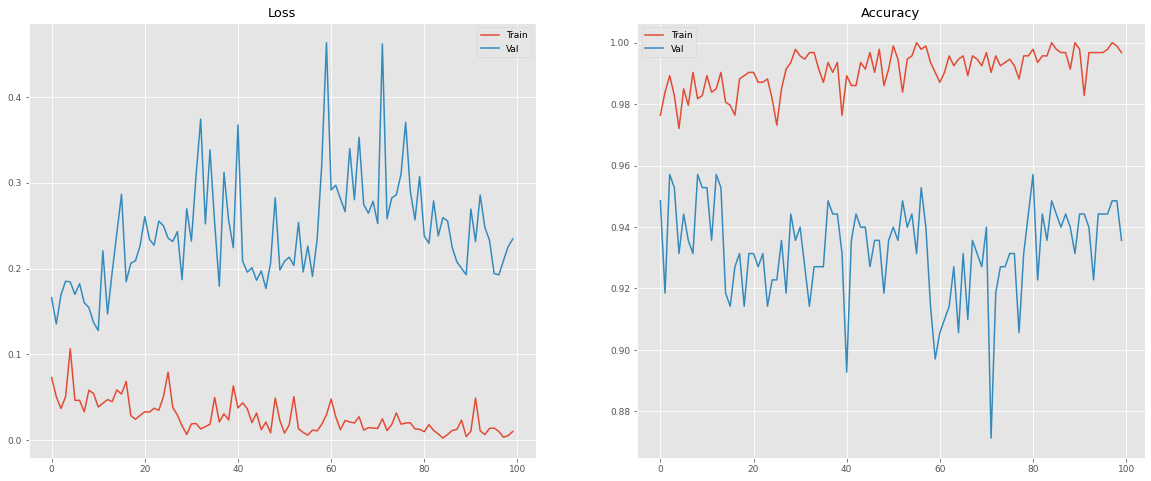

In [35]:
plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()